<a href="https://colab.research.google.com/github/AlineCrawf/data_science_projects_google_colab/blob/main/Image_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install image_slicer

     |████████████████████████████████| 2.2 MB 27.5 MB/s 
  Attempting uninstall: Pillow
    Found existing installation: Pillow 7.1.2
    Uninstalling Pillow-7.1.2:
      Successfully uninstalled Pillow-7.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pywt
from google.colab.patches import cv2_imshow
import pandas as pd
from tqdm import tqdm
import image_slicer
from os import listdir
from os.path import isfile, join

# Математическая морфология

Эрозия и Дилатация – два базовых, метода в операциях математической морфологии. Другие методы являются линейной комбинацией этих операторов. Если значение каждого пиксела в исходном изображении равно 1, соответствующем каждой 1 в ядре, означает, что ядро соответствует изображению, а если есть по крайней мере 1 пиксел, соответствующий вышеуказанному условию, говорят, что элемент попал в изображение.

## Код функций

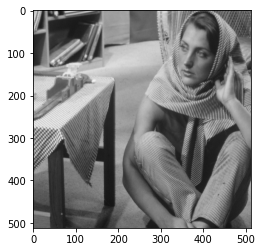

In [ ]:
img = cv2.imread('imgs/barbara.bmp', 1) # загрузка изображения
plt.imshow(img)

In [ ]:
def sp(img: np.ndarray, part: float)->np.ndarray:
    random_index = (np.random.rand(img.shape[0], img.shape[1])*100).astype(np.uint8) # генерируем случаный индексы
    output = np.copy(img) # делаем глубокую копию изображения
    output[random_index<=part] = 255 # заменяем значение пиксела
    return output

sp50 = sp(img, 50)

## Операция эрозии

В результате выполнения эрозии исходное изображение сжимается на эту же величину. Следует сразу отметить, что в результате выполнения эрозии на изображениях могут исчезнуть объекты, диаметр которых меньше диаметра структурирующего элемента.



In [ ]:
def erosian(img: np.ndarray, kernal: np.ndarray) -> np.ndarray:
    y = kernal.shape[0] // 2
    x = kernal.shape[1] // 2
    processed_image = np.copy(img)
    for i in range(y, img.shape[0] - y):
        for j in range(x, img.shape[1] - x):
            local_window = img[i-y:i+y+1, j-x:j+x+1]
            processed_image[i][j] = np.min(local_window[kernal])
    return processed_image 

##Операция дилатации 
Дилатация - метод обратный эрозии. Он расширяет структуру исходного изображения в зависимости от свертки структурирующего элемента с исходным изображением. Если элемент структурирования попадает в исходное изображение в пикселе p, значение устанавливается на 1, иначе 0. В результате выполнения дилатации могут окраситься впадины в объектах и пустоты в изображениях, чей диаметр меньше структурного элемента.

In [ ]:
def dilate(img: np.ndarray, kernal: np.ndarray) -> np.ndarray:
    y = kernal.shape[0] // 2
    x = kernal.shape[1] // 2
    processed_image = np.copy(img)
    for i in range(y, img.shape[0] - y):
        for j in range(x, img.shape[1] - x):
            local_window = img[i-y:i+y+1, j-x:j+x+1]
            processed_image[i][j] = np.max(local_window[kernal])
    return processed_image 

##Операция открытия (размыкиния)

Морфологическое размыкание удаляет те части объектов, в которых  структурный элемент полностью не помещается. 
Оно также сглаживает контуры объектов, разрушает тонкие соединения и удаляет острые выступы.


In [ ]:
def opening(img: np.ndarray, kernal: np.ndarray) -> np.ndarray:
    temp = erosian(img, kernal)
    output = dilate(temp, kernal)
    return output

## Операзия закрытия (замыкиния)

Морфологическое замыкание сглаживает контуры объектов, соединяет узкие разрывы, «заливает» длинные углубления малой ширины и заполняет малые отверстия.


In [ ]:
def closing(img: np.ndarray, kernal: np.ndarray) -> np.ndarray:
    temp = dilate(img, kernal)
    output = erosian(temp, kernal)
    return output

## Добавление шума

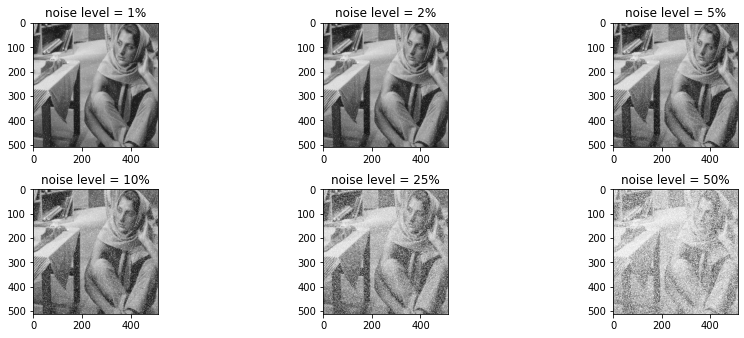

In [ ]:
def trim_axs(axs, N):
    """
    Reduce *axs* to *N* Axes. All further Axes are removed from the figure.
    """
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]
pie = [1, 2, 5, 10, 25, 50]
rows = len(pie)
cols = 3
axs = plt.figure(figsize=(12,12), constrained_layout=True).subplots(rows, cols)
axs = trim_axs(axs, rows)
for ax, part in zip(axs, pie):
    ax.set_title(f"noise level = {part}%")
    ax.imshow(sp(img, part))

In [ ]:
structs = {
    'cross3': np.array([[False,True,False],[True,True,True],[False,True,False]], dtype=bool),
    'rect3': np.ones((3,3), dtype=bool),
    'cross5': np.array([
        [False,False,True,False,False],
        [False,False,True,False,False],
        [True]*5,
        [False,False,True,False,False],
        [False,False,True,False,False]], dtype=bool),
    'rect5': np.ones((5,5), dtype=bool)
}

In [ ]:
opers = {
    'erosian':[erosian(sp50,structs[kernel]) for kernel in structs],
    'dilate':[dilate(sp50,structs[kernel]) for kernel in structs],
    'opening':[opening(sp50,structs[kernel]) for kernel in structs],
    'close':[closing(sp50,structs[kernel]) for kernel in structs]
}

## Графики

(nº of repetitions vertically, nº of repetitions horizontally, 1)

Take in consideration that the value 1 means no repetition, just the original values across that axis.

## Эрозия

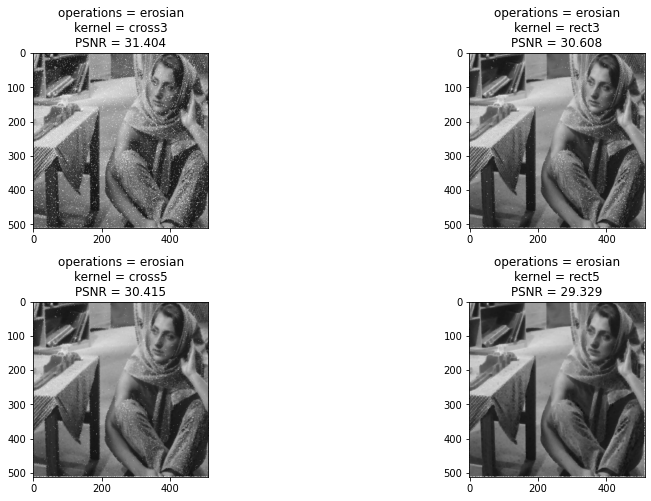

In [ ]:
rows = 4
cols = 2
axs = plt.figure(figsize=(12,12), constrained_layout=True).subplots(rows, cols)
axs = trim_axs(axs, rows)
for ax, oper, kernel in zip(axs, opers['erosian'], structs):
  ax.set_title(f"operations = erosian\nkernel = {kernel}\nPSNR = {PSNR(img, oper)}")
  ax.imshow(oper)


## Дилатация

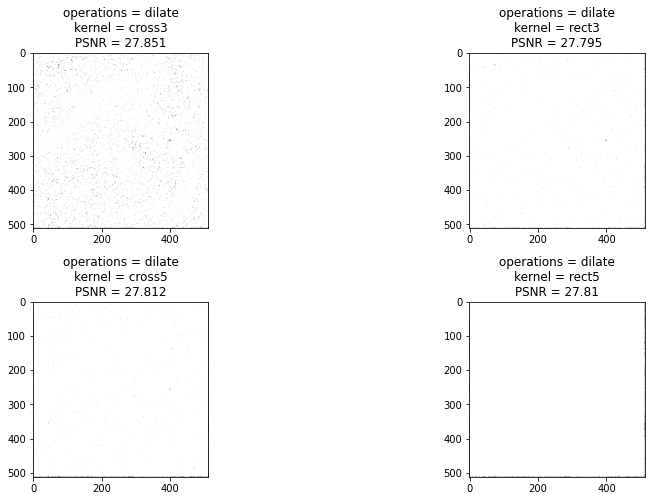

In [ ]:
rows = 4
cols = 2
axs = plt.figure(figsize=(12,12), constrained_layout=True).subplots(rows, cols)
axs = trim_axs(axs, rows)
for ax, oper, kernel in zip(axs, opers['dilate'], structs):
    ax.set_title(f"operations = dilate\nkernel = {kernel}\nPSNR = {PSNR(img, oper)}")
    ax.imshow(oper)

## Открытие

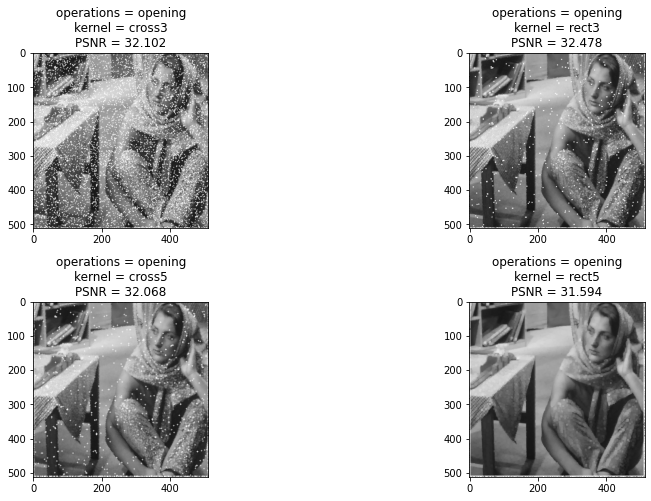

In [ ]:
rows = 4
cols = 2
axs = plt.figure(figsize=(12,12), constrained_layout=True).subplots(rows, cols)
axs = trim_axs(axs, rows)
for ax, oper, kernel in zip(axs, opers['opening'], structs):
    ax.set_title(f"operations = opening\nkernel = {kernel}\nPSNR = {PSNR(img, oper)}")
    ax.imshow(oper)

## Закрытие

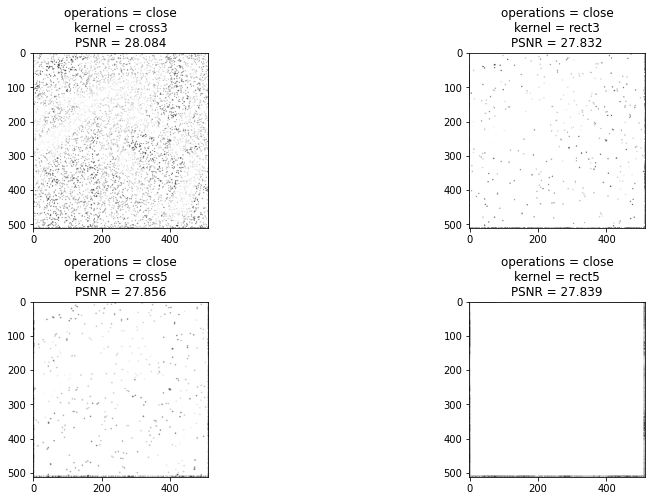

In [ ]:
rows = 4
cols = 2
axs = plt.figure(figsize=(12,12), constrained_layout=True).subplots(rows, cols)
axs = trim_axs(axs, rows)
for ax, oper, kernel in zip(axs, opers['close'], structs):
    ax.set_title(f"operations = close\nkernel = {kernel}\nPSNR = {PSNR(img, oper)}")
    ax.imshow(oper)

# JPEG 2000

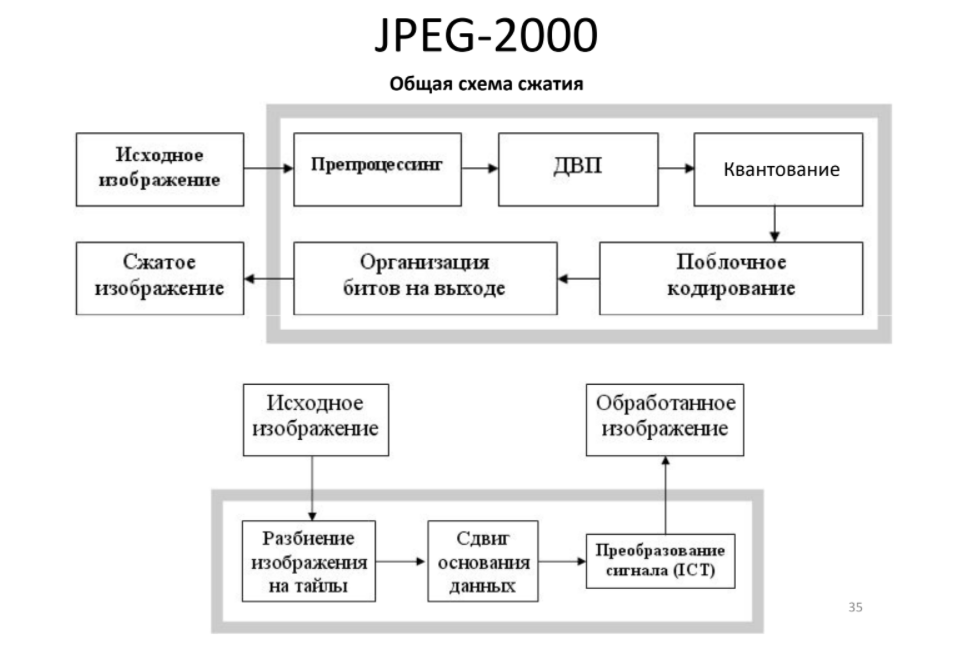

## 0 : Разбивка изображения на блоки

In [ ]:
img = cv2.imread('imgs/barbara.bmp')
tile = np.tile(img,(2, 1,1));

In [ ]:
!pip install image_slicer

## 1. Выравнивание динамического диапазона

In [ ]:
imgs =  cv2.imread("imgs/barbara.bmp")
imgs = np.float32(imgs)

imgs = imgs - pow(2, 8 - 1)

## 2. Преобразование RGB -> YCbCr

In [ ]:
imgs = cv2.cvtColor( imgs, cv2.COLOR_RGB2YCrCb)

## 3. DWT 
При сжатии без потерь используется целочисленный вейвлет 5/3

In [ ]:
import pywt

img = pywt.wavedec(imgs, 'db1', level=3)

/usr/local/lib/python3.7/dist-packages/pywt/_multilevel.py:45: UserWarning: Level value of 3 is too high: all coefficients will experience boundary effects.
  "boundary effects.").format(level))


## 4. Квантование

Квантование изображения включает дискретизацию значений интенсивности аналогового изображения.

In [ ]:
imgs = cv2.cvtColor(imgs, cv2.COLOR_YCrCb2RGB)
imgs = cv2.cvtColor(imgs, cv2.COLOR_RGB2GRAY)

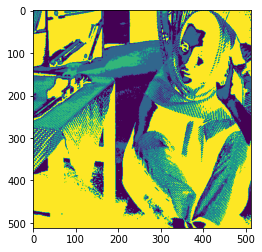

In [ ]:
k = 4 # Шаг квантования

bins = np.linspace(0, imgs.max(), k)
image = np.digitize(imgs, bins)
image = (np.vectorize(bins.tolist().__getitem__)
                      (image-1).astype(int))
plt.imshow(image)

imgs = image

## 5. Энтропийное кодирование

In [ ]:
img = np.int32(imgs)
img.shape

(512, 512)

### Представление изображения в бинарном коде

(512, 512)

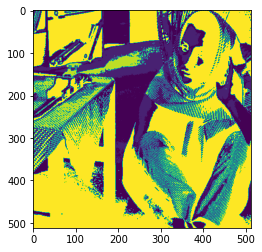

In [ ]:
for x in range(img.shape[0]):
  for y in range(img.shape[1]):
      img[x,y] = np.binary_repr(img[x,y])
plt.imshow(img)
img.shape

In [ ]:
img.shape

(512, 512)

In [ ]:
# We have a list of strings where each string represents binary pixel value. To extract bit planes we need to iterate over the strings and store the characters corresponding to bit planes into lists.
# Multiply with 2^(n-1) and reshape to reconstruct the bit image.

def entropy_coding(img):
  pixels = 8
  matrix = []

  img = np.int32(img)

  for x in range(img.shape[0]):
    for y in range(img.shape[1]):
        img[x,y] = np.binary_repr(img[x,y])

  lst = img
  for idx in range(pixels):
    matrix.append( ( np.array([int(i[idx]) for i in lst]) \
                    * pow(2, 7 - idx)\
                    ).reshape(img.shape[0],img.shape[1])
                )

  #Concatenate these images for ease of display using cv2.hconcat()
  finalr = cv2.hconcat([matrix[0], matrix[1], matrix[2], matrix[3]])
  finalv = cv2.hconcat([matrix[4], matrix[5], matrix[6], matrix[7]])

  # Vertically concatenate
  final = cv2.vconcat([finalr,finalv])
  
  # Display the images
  cv2_imshow(final)
  cv2.waitKey(0) 




[вейвлет-преобразование](https://coderoad.ru/24536552/%D0%9A%D0%B0%D0%BA-%D0%BE%D0%B1%D1%8A%D0%B5%D0%B4%D0%B8%D0%BD%D0%B8%D1%82%D1%8C-pyWavelet-%D0%B8-openCV-%D0%B4%D0%BB%D1%8F-%D0%BE%D0%B1%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%BA%D0%B8-%D0%B8%D0%B7%D0%BE%D0%B1%D1%80%D0%B0%D0%B6%D0%B5%D0%BD%D0%B8%D0%B9)

In [ ]:
def w2d(img, mode='haar', level=1):
    #imArray = cv2.imread(img)
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imgs, cv2.COLOR_YCR_CB2RGB )
    imArray = cv2.cvtColor( imgs, cv2.COLOR_RGB2GRAY)
    #convert to float
    img =  np.float32(img)   
    img /= 255;
    # compute coefficients 
    coeffs=pywt.wavedec2(img, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    imArray_H  = cv2.cvtColor( imArray_H , cv2.COLOR_GRAY2RGB )
    #Display result
    cv2_imshow(imArray_H)
    cv2.waitKey(0)

    return(imArray_H)

In [ ]:
!pip install simplejpeg

     |████████████████████████████████| 271 kB 8.1 MB/s 


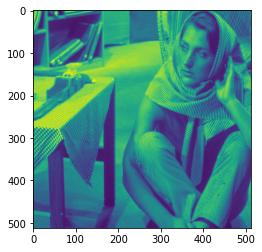

In [ ]:
img = plt.imread('imgs/barbara.bmp')
img_jpeg = plt.imread('imgs/barbara.jpg')

plt.imshow(img_jpeg)

In [ ]:
PSNR(img, img_jpeg)

58.455

# Лабораторная 1. Модельні полігармонічні сигнали

Користуючись скалярним добутком як мірою подібності, знайти «близькість» першого сигналу до інших і зробити висновки. Амплітуди для високочастотних компонент встановити «меншими» порівняно з несучою частотою, а для випадкового аддитивного шуму «значно меншими». 


In [ ]:
import matplotlib.pyplot as plt 
import numpy as np 
import pprint 
from scipy.fftpack import fft, ifft
from numpy import pi, exp
from scipy.signal import convolve

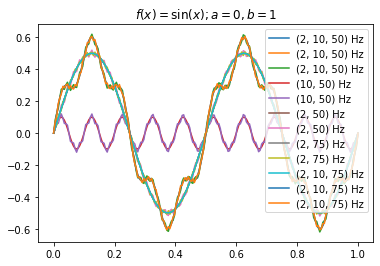

scalar product:
[[25.87,
  25.87,
  25.87,
  0.99,
  0.99,
  24.88,
  24.88,
  24.89,
  24.89,
  25.89,
  25.89,
  25.89]]


In [ ]:
x = np.linspace(0, 1, 200) 
frequencies = [ 
 (2, 10, 50), 
 (10, 50), 
 (2, 50), 
 (2, 75), 
 (2, 10, 75), 
] 
y_array = [] 
for freq in frequencies: 
 A = np.array(freq, dtype=float) ** -1 
 y = 0 
 for i in range(len(freq)): 
  y += A[i] * np.sin(2 * np.pi * freq[i] * x) 
  y_array.append(y) 
  plt.plot(x, y, label=str(freq) + " Hz") 
plt.title(r"$np.sin(x)=\sin(x); a=0, b=1$") 
plt.legend() 
plt.show() 
scalar_difference_matrix = [] 
for i in y_array: 
  scalar_difference_matrix_tmp = [] 
  for j in y_array:
    scalar_difference_matrix_tmp.append(round(np.dot(i, j),  2)) 
  
scalar_difference_matrix.append(scalar_difference_matrix_tmp) 
print("scalar product:") 
pprint.pprint(scalar_difference_matrix) 


# Лабораторная 2. Модельні сигнали та їх амплітудно-частотні спектри
Створити модельні нелінійні стаціонарні, лінійні нестаціонарні, нелінійні нестаціонарні сигнали з частотами 2, 10 і 75 Hz. Побудувати їх амплітудно-частотні спектри. Зробити висновки.



In [ ]:
a = 0
b = 1
N = 200

x = np.linspace(a, b, N)
dx = (b - a) / N

nu = np.array([2, 10, 75], dtype=float)
A = nu ** -1

In [ ]:
def AFS(signal):    
  fft_signal = fft(signal)
  magnitude = np.abs(fft_signal)[: int(N / 2)]
  fd = 1 / dx
  F = np.linspace(0, int(N / 2) - 1, int(N / 2)) / N * fd

  return F, magnitude

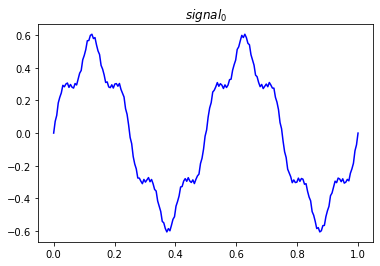

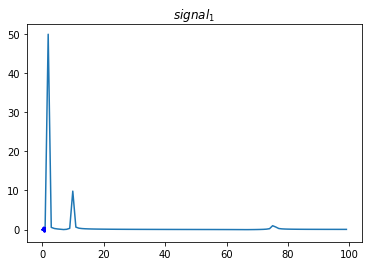

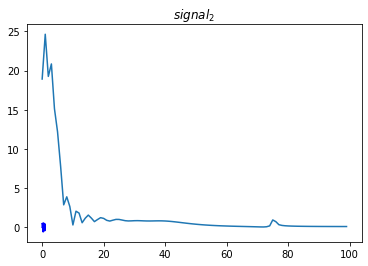

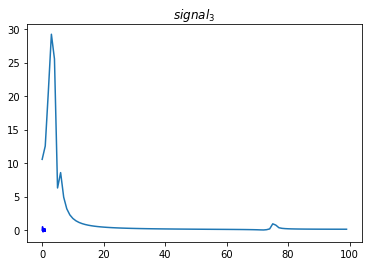

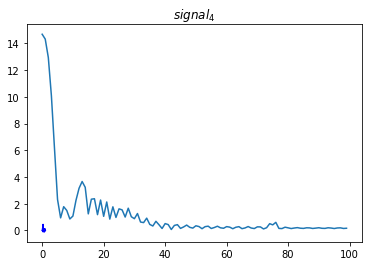

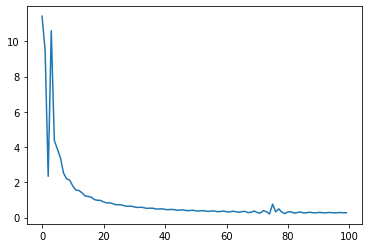

In [ ]:
signals = [
    A[0] * np.sin(2 * pi * nu[0] * x) + 
    A[1] * np.sin(2 * pi * nu[1] * x) + 
    A[2] * np.sin(2 * pi * nu[2] * x),  # signal 1
    
    A[0] * np.sin(2 * pi * nu[0] * x ** 3) + 
    A[1] * np.sin(2 * pi * nu[1] * x ** 5) + 
    A[2] * np.sin(2 * pi * nu[2] * x),  # signal 2
    
    A[0] * np.sin(2 * pi * nu[0] * exp(x)) + 
    A[1] * np.sin(2 * pi * nu[1] * x ** 1/2) + 
    A[2] * np.sin(2 * pi * nu[2] * x),  # signal 3
    
    (x < 0.3) * (A[0] * np.sin(2 * pi * nu[0] * x)) + 
    (x > 0.3) * (A[1] * np.sin(2 * pi * nu[1] * np.tan(x))) + 
    (x >= 0.6) * (A[2] * np.sin(2 * pi * nu[2] * x)),  # signal 4
    
    (x < 0.3) * (A[0] * np.sin(2 * pi * nu[0] * x ** 2)) + 
    (x > 0.3) * (A[1] * np.sin(2 * pi * nu[1] * x ** 1/4)) + 
    (x >= 0.6) * (A[2] * np.sin(2 * pi * nu[2] * x)),  # signal 5
]

for i in range(len(signals)):
    # signal
    plt.plot(x, signals[i], "b")
    plt.title(label=f"$ signal_{i}$")
    plt.show()   
    
    # Amplitude Frequency Spectrum
    F, magnitude = AFS(signals[i])

    plt.plot(F, magnitude)


# Лабораторная 3.  Випадковий шум і його видалення. Порівняльний аналіз методів

До першого сигналу попередньої задачі додати випадковий шум і потім видалити його з застосування:

згортки сигналу з фільтром усереднення довжиною 3, 7, 21;
прямого і оберненого перетворення Фур’є шляхом занулення високих частот. Підібрати найкращий поріг занулення відповідних коефіцієнтів Фур’є-спектру сигналу.
Порівняти результуючий сигнал (після видалення шуму) з вхідним сигналом застосовуючи метрику SNR (Signal-Noise Ratio).

In [ ]:
def SNR(signal: np.array, noise: np.array):
  return 10 * np.log10((np.dot(signal, signal)) ** 2 / (np.dot(noise, noise)) ** 2)


In [ ]:
a = 0
b = 1
N = 200
x = np.linspace(a, b, N)
nu = np.array([2, 10, 75], dtype=float)
A = nu ** -1
s = (
      A[0] * np.sin(2 * np.pi * nu[0] * x) +
      A[1] * np.sin(2 * np.pi * nu[1] * x) +
      A[2] * np.sin(2 * np.pi * nu[2] * x)
)


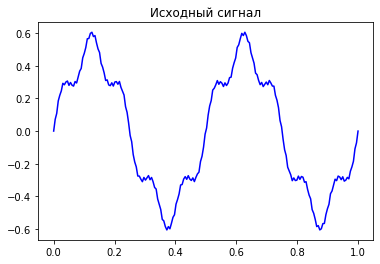

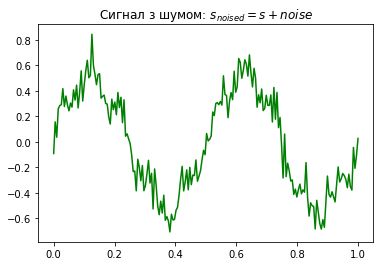

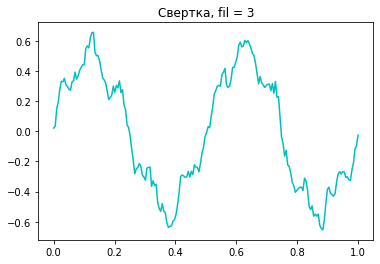

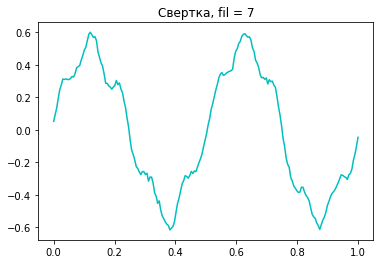

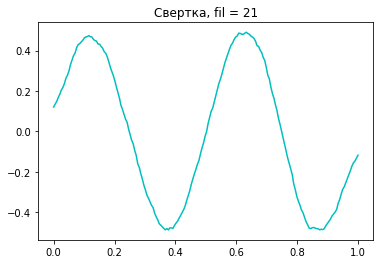

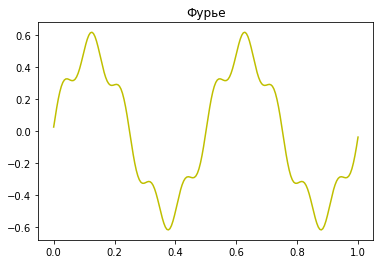

{'conv f=21': [0.7291609468947124],
 'conv f=3': [-0.8261185701450068],
 'conv f=7': [-0.5625661766728217],
 'fft': [-0.7457649091547436]}


In [ ]:
plt.plot(x, s, c="b")
plt.title("Исходный сигнал")
plt.show()

s_noised = s + np.random.randn(len(s)) / 10
plt.plot(x, s_noised, "g")
plt.title("Сигнал з шумом: $s_{noised} = s + noise$")
plt.show()

results = {}
for i in [3, 7, 21]:
  filt = np.ones(i) / i
  s_conv = convolve(s_noised, filt, mode="same")
  plt.plot(x, s_conv, "c")
  plt.title(f"Свертка, fil = {i}")
  plt.show()
  results[f"conv f={i}"] = [SNR(signal=s, noise=s_conv)]

fft_y = fft(s_noised)
magnitude = np.abs(fft_y)
threshold = (max(magnitude) - min(magnitude)) / 8
L = magnitude > threshold
fft_y_thresh = np.multiply(fft_y, L)
s_appr = ifft(fft_y_thresh).real
plt.plot(x, s_appr, "y")
plt.title("Фурье")
plt.show()
results["fft"] = [SNR(signal=s, noise=s_appr)]
pprint.pprint(results)

# Лабораторная 4. Методи видалення шуму з зображень

Для вхідних зображень Lena, Barbara and Boat (grayscale) виконати згладжування рядків і стовпчиків шляхом:

1. згортки зображення з фільтром (маскою) розмиття розміром 3, 7, 21;
2. прямого і оберненого перетворення Фур’є шляхом занулення високих частот по емпірично підібраному трешхолду. Підібрати найкращий поріг занулення відповідних коефіцієнтів Фур’є сигналу. Трешхолдинг частот і наступне відновлення зображення називається нелінійною апроксимацією;
3. шляхом побудови спектру зображення, наступним стягуванням низьких частот в центр зображення за допомогою функції fftshift(), емпіричним визначенням розміру квадрату низьких частот (наприклад, …, 64, …, 128, …, ) і зануленням високих (фур’є коефіцієнти за межами квадрату), відновленням сигналу шляхм послідовного виконання зворотного зсуву ifftshift() та оберненого перетворення ifft2(). 


Зробити висновки стосовно якості результуючих зображень шляхом порівняння з оригінальними зображеннями з застосуванням метрики PSNR (Peak Signal-Noise Ratio).


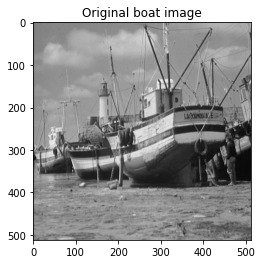

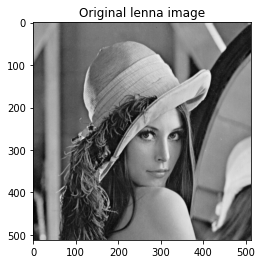

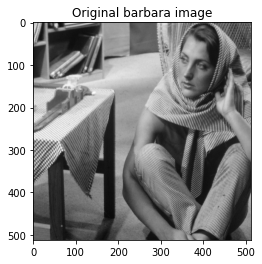

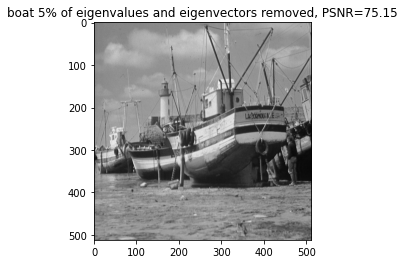

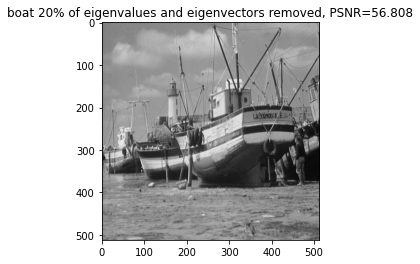

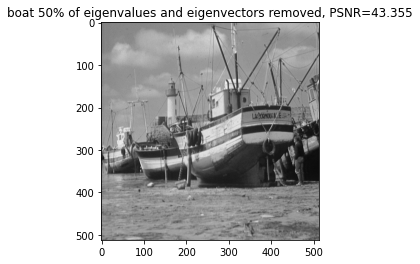

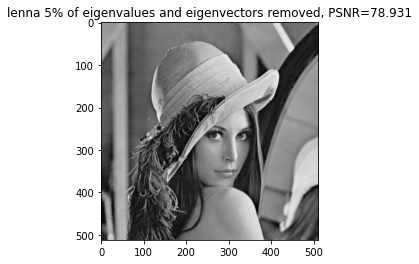

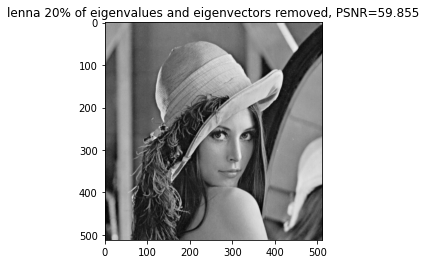

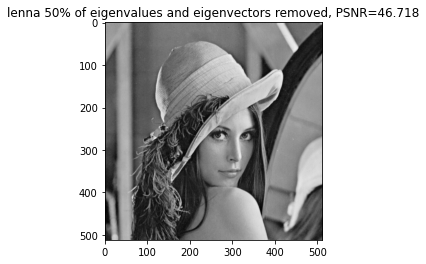

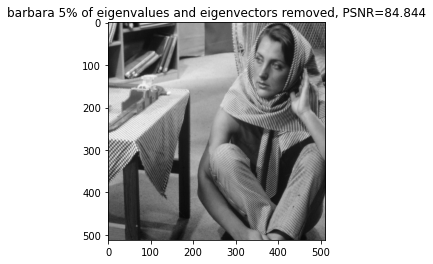

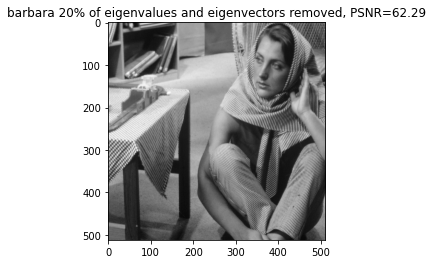

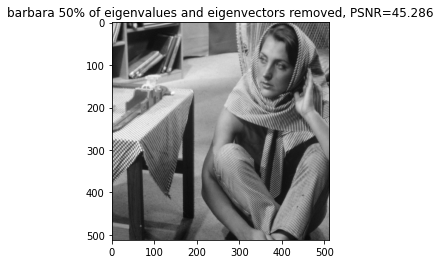

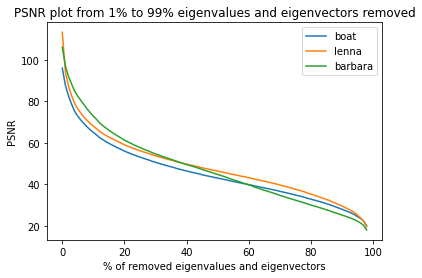

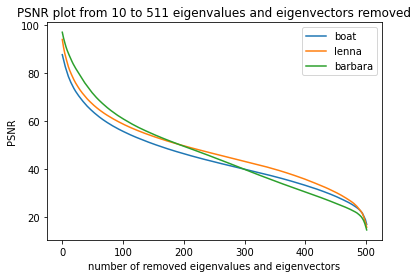

In [ ]:
def PSNR(original: np.array, compressed: np.array) -> float:
    assert original.shape == compressed.shape
    mse = np.mean((original - compressed) ** 2)
    if mse == 0:
        return 100
    return round(20 * np.log10(255 / np.sqrt(mse)), 3)


def svd_approx(img: np.array, percent: int = 5) -> np.array:
    l = img.shape[0]
    num = round(l * percent / 100)

    U, S, V = np.linalg.svd(img)
    s = np.diag(S)

    U = U[:, : l - num]
    s = s[: l - num, : l - num]
    V = V[: l - num]

    return U @ s @ V


def svd_approx_by_num(img: np.array, num: int = 20) -> np.array:
    l = img.shape[0]

    U, S, V = np.linalg.svd(img)
    s = np.diag(S)

    U = U[:, : l - num]
    s = s[: l - num, : l - num]
    V = V[: l - num]

    return U @ s @ V


if __name__ == "__main__":
    imgs = {
        "boat": np.array(plt.imread("imgs/boat.bmp"), dtype=np.float64),
        "lenna": np.array(plt.imread("imgs/lena2.bmp"), dtype=np.float64),
        "barbara": np.array(plt.imread("imgs/barbara.bmp"), dtype=np.float64),
    }
    for name in imgs:
        plt.imshow(imgs[name], cmap="gray")
        plt.title(f"Original {name} image")
        plt.show()

    for name in imgs:
        for perc in [5, 20, 50]:
            tmp_img = svd_approx(imgs[name], perc)
            plt.imshow(tmp_img, cmap="gray")
            plt.title(
                f"{name} {perc}% of eigenvalues and eigenvectors removed, PSNR="
                + str(PSNR(imgs[name], tmp_img))
            )
            plt.show()

    for name in imgs:
        psnr_perc_list = []
        for p in range(1, 100):
            psnr_perc_list.append(PSNR(imgs[name], svd_approx(imgs[name], p)))
        plt.plot(psnr_perc_list, label=name)
    plt.title("PSNR plot from 1% to 99% eigenvalues and eigenvectors removed")
    plt.xlabel("% of removed eigenvalues and eigenvectors")
    plt.ylabel("PSNR")
    plt.legend()
    plt.show()

    for name in imgs:
        psnr_num_list = []
        for n in range(10, 512):
            psnr_num_list.append(PSNR(imgs[name], svd_approx_by_num(imgs[name], n)))
        plt.plot(psnr_num_list, label=name)
    plt.title("PSNR plot from 10 to 511 eigenvalues and eigenvectors removed")
    plt.xlabel("number of removed eigenvalues and eigenvectors")
    plt.ylabel("PSNR")
    plt.legend()
    plt.show()


# Лабораторная 5. Апроксимація зображення з допомогою сингулярного розкладу

Виконати апроксимацію тестових зображень за допомогою SVD (Singular Value Decomposition):
1. знайти три матриці;
2. занулити 5, 20, і 50% власних значень з найменшими абсолютними значеннями і видалити відповідні власні вектори;
3. відновити зображення.

Зробити висновки, порівнюючи отримані зображеннями з оригіналом, результатами лінійної , нелінійної Фур’є апроксимації. Акцентувати увагу під час висновків на кількості інформації, яка «зануляється» в кожному випадку та якості зображення.


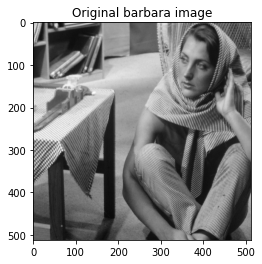

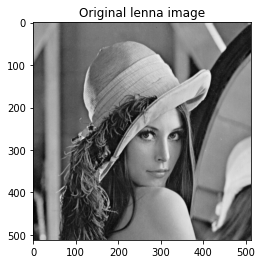

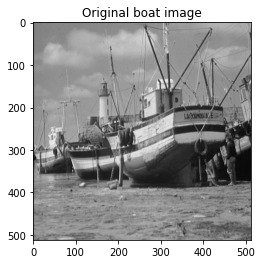

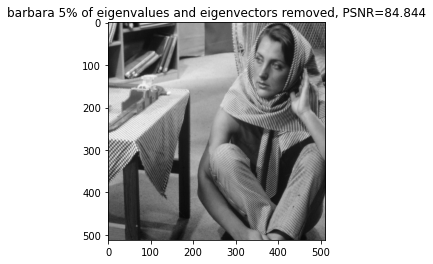

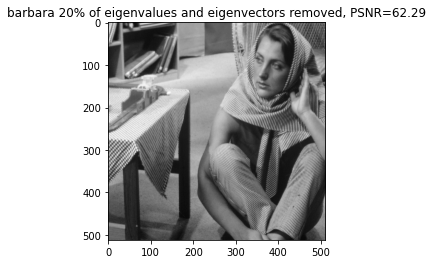

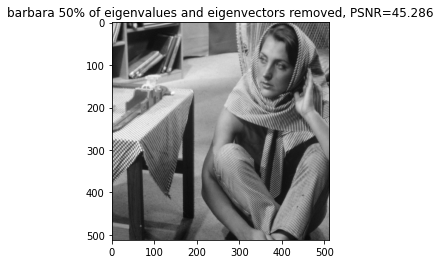

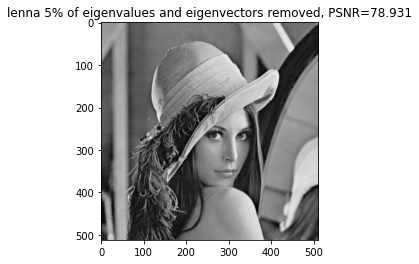

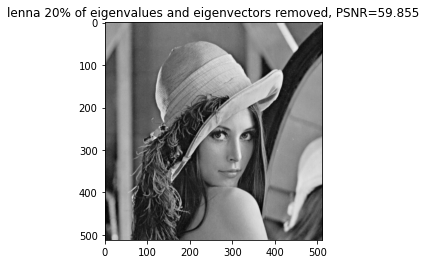

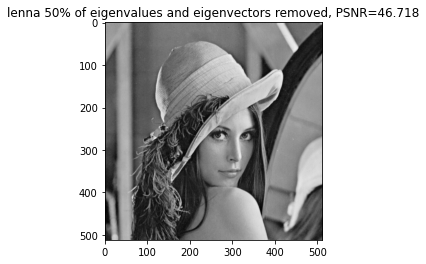

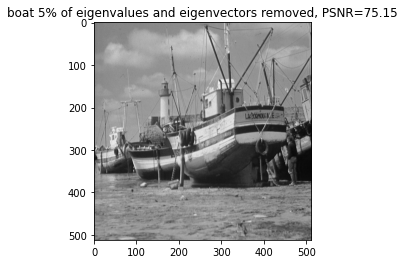

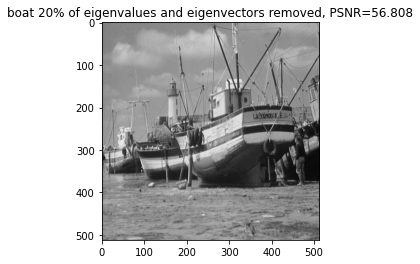

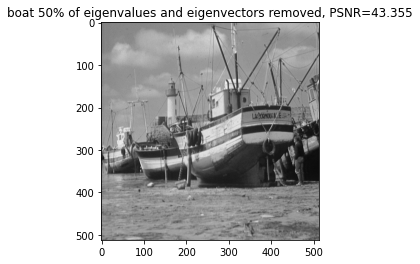

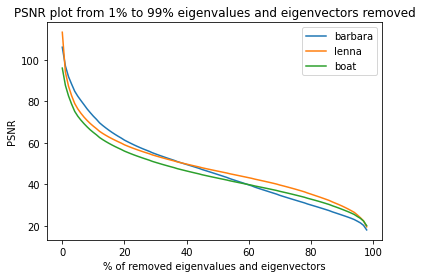

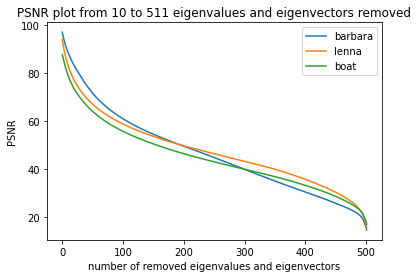

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
 
 
def PSNR(original: np.array, compressed: np.array) -> float:
    assert original.shape == compressed.shape
    mse = np.mean((original - compressed) ** 2)
    if mse == 0:
        return 100
    return round(20 * np.log10(255 / np.sqrt(mse)), 3)
 
 
def svd_approx(img: np.array, percent: int = 5) -> np.array:
    l = img.shape[0]
    num = round(l * percent / 100)
 
    U, S, V = np.linalg.svd(img)
    s = np.diag(S)
 
    U = U[:, : l - num]
    s = s[: l - num, : l - num]
    V = V[: l - num]
 
    return U @ s @ V
 
 
def svd_approx_by_num(img: np.array, num: int = 20) -> np.array:
    l = img.shape[0]
 
    U, S, V = np.linalg.svd(img)
    s = np.diag(S)
 
    U = U[:, : l - num]
    s = s[: l - num, : l - num]
    V = V[: l - num]
 
    return U @ s @ V
 
 
if __name__ == "__main__":
    imgs = {        
        "barbara": np.array(plt.imread("imgs/barbara.bmp"), dtype=np.float64),
        "lenna": np.array(plt.imread("imgs/lena2.bmp"), dtype=np.float64),
        "boat": np.array(plt.imread("imgs/boat.bmp"), dtype=np.float64),
    }
    for name in imgs:
        plt.imshow(imgs[name], cmap="gray")
        plt.title(f"Original {name} image")
        plt.show()
 
    for name in imgs:
        for perc in [5, 20, 50]:
            tmp_img = svd_approx(imgs[name], perc)
            plt.imshow(tmp_img, cmap="gray")
            plt.title(
                f"{name} {perc}% of eigenvalues and eigenvectors removed, PSNR="
                + str(PSNR(imgs[name], tmp_img))
            )
            plt.show()
 
 
    for name in imgs:
        psnr_perc_list = []
        for p in range(1, 100):
            psnr_perc_list.append(PSNR(imgs[name], svd_approx(imgs[name], p)))
        plt.plot(psnr_perc_list, label=name)
    plt.title("PSNR plot from 1% to 99% eigenvalues and eigenvectors removed")
    plt.xlabel("% of removed eigenvalues and eigenvectors")
    plt.ylabel("PSNR")
    plt.legend()
    plt.show()
 
    for name in imgs:
        psnr_num_list = []
        for n in range(10, 512):
            psnr_num_list.append(PSNR(imgs[name], svd_approx_by_num(imgs[name], n)))
        plt.plot(psnr_num_list, label=name)
    plt.title("PSNR plot from 10 to 511 eigenvalues and eigenvectors removed")
    plt.xlabel("number of removed eigenvalues and eigenvectors")
    plt.ylabel("PSNR")
    plt.legend()
    plt.show()


# Лабораторная 6. 

Довести нестаціонарність зображення, як сигналу, шляхом його розбиття на блоки розмірами 8, 16, 64 пікселі та побудови відповідних спектрів для кожного блоку. В результаті має бути зображення замощене спектрами відповідних блоків. Зробити висновки для кожного з тестових зображень.


In [ ]:

imput_image = cv2.imread('imgs/barbara.bmp')
col_numb = 64

def slice_img(img_path, col_numb):
  return image_slicer.slice(img_path, col = col_numb, row = col_numb )
  

imput_image.shape 
slice_tuple = slice_img('slice/barbara.bmp', col_numb )

imput_image1 = cv2.imread('slice/barbara_01_01.png')
imput_image1.shape

AttributeError: ignored

In [ ]:
onlyfiles = [f for f in listdir('slice') if isfile(join('slice', f))]

onlyfiles.remove('barbara.bmp')

In [ ]:
images = []

for img in onlyfiles:
  images.append(cv2.imread(f'slice/{img}', 0))

for i in images:
  print(i.shape)

In [ ]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

img = cv2.imread('imgs/barbara.bmp')

def spectrum(img):
  img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  dft = np.fft.fft2(img)
  dft_shift = np.fft.fftshift(dft)
  phase_spectrum = np.angle(dft_shift)

  return phase_spectrum


In [ ]:
images_recovered = [ recover(i) for i in images]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: ComplexWarning: Casting complex values to real discards the imaginary part


In [ ]:
rows = 64
cols = 8
axs = plt.figure(figsize=(12,12), constrained_layout=True).subplots(rows, cols)
axs = trim_axs(axs, rows)
for ax, part in zip(axs, images_recovered[0:64]):
    ax.imshow(part)

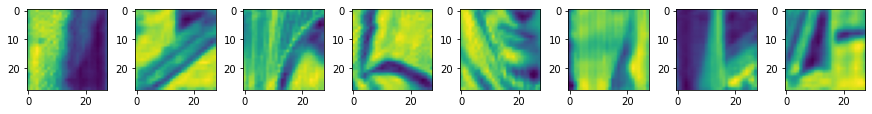

In [ ]:
rows = 8
cols = 8
axs = plt.figure(figsize=(12,12), constrained_layout=True).subplots(rows, cols)
axs = trim_axs(axs, rows)
for ax, part in zip(axs, images_recovered[8:16]):
    ax.imshow(part)

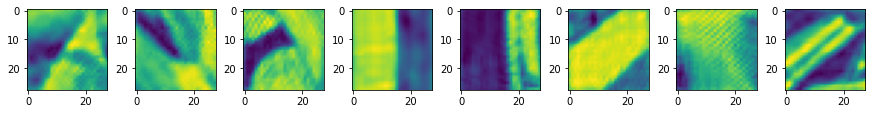

In [ ]:
rows = 8
cols = 8
axs = plt.figure(figsize=(12,12), constrained_layout=True).subplots(rows, cols)
axs = trim_axs(axs, rows)
for ax, part in zip(axs, images_recovered[16:24]):
    ax.imshow(part)

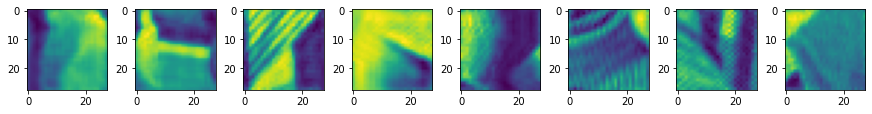

In [ ]:
rows = 8
cols = 8
axs = plt.figure(figsize=(12,12), constrained_layout=True).subplots(rows, cols)
axs = trim_axs(axs, rows)
for ax, part in zip(axs, images_recovered[24:32]):
    ax.imshow(part)

In [ ]:
def image_split(image, rows, columns):
    h, w = image.shape
    return (
        image.reshape(h // rows, rows, -1, columns)
        .swapaxes(1, 2)
        .reshape(-1, rows, columns)
    )


In [ ]:
images = {
    "boat": np.array(plt.imread("imgs/boat.bmp"), dtype = float),
    "barbara": np.array(plt.imread("imgs/barbara.bmp"), dtype = float),
}

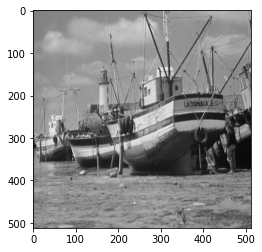

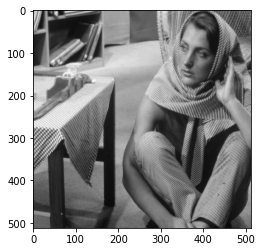

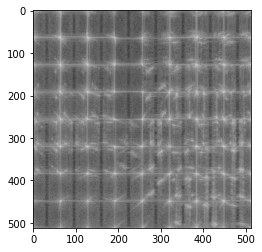

In [ ]:
for name, img in images.items():
    plt.imshow(img, "gray")
    plt.show()
 
    for j in [8, 16, 64]:
        rows = 512 // j
        a = image_split(img, j, j)
        b = np.array([example(i) for i in a])
        res = np.concatenate([np.concatenate(b[i : i + rows], axis=1) for i in range(0, b.shape[0], rows)], axis = 0,)
 
    plt.imshow(res, "gray")

In [ ]:
def PSNR(original: np.array, compressed: np.array) -> float:
    assert original.shape == compressed.shape
    mse = np.mean((original - compressed) ** 2)
    if mse == 0:
        return 100
    return round(20 * np.log10(255 / np.sqrt(mse)), 3)

In [ ]:


import matplotlib.image as img
from scipy import signal
from scipy import misc
from scipy.fftpack import fft2, ifft2, fftshift, ifftshift
  
# reading the image 
IO = img.imread('imgs/barbara.bmp') 

"""
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

I = np.array(rgb2gray(IO) )

"""
def example(IO):
  I = IO
  M, N = I.shape


  Rh = int(M/2)
  Ch = int(N/2)
  
  # displaying the image 
  #plt.figure(10)
 # plt.title('Input image')
 # plt.imshow(I) 

  # Bluring of grayscale image

  # Create the bluring mask - square matrix (summa of elements is 1)
  k = 5
  Mask = np.ones((k, k)) / pow(k, 2)

  # Discrete convolution of 2D areas, padding is defined by 2-d and 3-d parameter. It's obvious from their values.
  Iblured = signal.convolve2d(I, Mask, boundary='symm', mode='same')

  #plt.figure(11)
  #plt.title('Blured image in the image domain')
  #plt.imshow(Iblured, cmap=plt.get_cmap('gray')) 

  # Image Fourier transformatio
  FI = fft2(I)
  PFI = np.abs(FI)

  eps = np.finfo(np.float).eps
  LPFI = np.log(eps + PFI)

  #plt.figure(12)
  #plt.title('Spectrum of image')
  #plt.imshow(LPFI, cmap=plt.get_cmap('gray')) 

  return(LPFI)

  

example(IO)


array([[17.24217443, 14.33267495, 14.37532597, ..., 12.49252195,
        14.37532597, 14.33267495],
       [15.1415422 , 14.98107325, 14.21127252, ..., 13.93702151,
        13.60822749, 12.60394963],
       [13.88089094, 14.1259545 , 13.73263889, ..., 13.24689592,
        13.78529634, 13.39009715],
       ...,
       [11.69065309, 13.25145756, 13.1012435 , ..., 14.19548929,
        13.12889357, 12.63586054],
       [13.88089094, 13.39009715, 13.78529634, ..., 13.87871479,
        13.73263889, 14.1259545 ],
       [15.1415422 , 12.60394963, 13.60822749, ..., 13.98583128,
        14.21127252, 14.98107325]])

In [ ]:
def recover(IO):
  I = IO
  M, N = I.shape


  Rh = int(M/2)
  Ch = int(N/2)
  # Bluring of grayscale image

  # Create the bluring mask - square matrix (summa of elements is 1)
  k = 5
  Mask = np.ones((k, k)) / pow(k, 2)

  # Discrete convolution of 2D areas, padding is defined by 2-d and 3-d parameter. It's obvious from their values.
  Iblured = signal.convolve2d(I, Mask, boundary='symm', mode='same')

  FI = fft2(I)
  PFI = np.abs(FI)

  eps = np.finfo(np.float).eps
  LPFI = np.log(eps + PFI) 
  FILA = np.zeros(FI.shape, dtype=complex)
  FI_shifted = fftshift(FI)
  d = 32  # Play with 16, 32, 64, 128

  FILA[Rh-d:Rh+d, Ch-d:Ch+d] = FI_shifted[Rh-d:Rh+d, Ch-d:Ch+d]

  FI_recovered = ifftshift(FILA)
  I_recovered  = ifft2(FI_recovered)

  return I_recovered.astype(float)